## Introduction

In this project, we will analyze the spread of the new corona virus (nCov). We will use two datasets:
    - The John Hopkins University's dataset which contains aggregated daily data for confirmed cases, deaths and recovered patients. 
    https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series
    - The DXY.cn's google sheet which contains information of about 1000 patients. 
    https://docs.google.com/spreadsheets/d/1jS24DjSPVWa4iuxuD4OAXrE3QeI8c9BC1hSlqr-NMiU/edit#gid=1187587451


Son Huynh
29.02.2020

About getting dataset:

The reddit's datasets group is a good place to look for datasets. For example, you can check out useful sources for nCov data from here: https://www.reddit.com/r/datasets/comments/exnzrd/coronavirus_datasets/

Reddit in general is great for getting tips and browsing discussions. Some of my favorite subreddits are dataisbeautiful, datascience, MachineLearning.


In [1]:
%matplotlib inline


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
url_case = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_death = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_cured = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

Let's take a look at the case time series first

In [3]:
case_cum = pd.read_csv(url_case)

death_cum = pd.read_csv(url_death)
cured_cum = pd.read_csv(url_cured)

# all data has columns referring to date extract that
dates=case_cum.columns[4:].values
datestrs=[]
for date in dates: 
    nums=np.fromstring(date,dtype=np.uint8,sep='/')
    datestrs.append(datetime.datetime(nums[2],nums[0],nums[1]).isoformat()[2:10])

dates=pd.to_datetime(datestrs, format='%y-%m-%d', errors='coerce')
#print(dates)

#change awkward columns
case_cum.rename(columns={'Country/Region':'countryreg','Province/State':'provstate'},inplace=True)
death_cum.rename(columns={'Country/Region':'countryreg','Province/State':'provstate'},inplace=True)
cured_cum.rename(columns={'Country/Region':'countryreg','Province/State':'provstate'},inplace=True)

#replace NaN values by ' ' 
case_cum.provstate=case_cum.provstate.fillna('')
death_cum.provstate=case_cum.provstate.fillna('')
cured_cum.provstate=case_cum.provstate.fillna('')

# change indeces to first two columns
case_cum.set_index(['countryreg','provstate'],inplace=True)
death_cum.set_index(['countryreg','provstate'],inplace=True)
cured_cum.set_index(['countryreg','provstate'],inplace=True)

#take locations first (never know if we'll anyway need it)
locations=case_cum.iloc[:,0:4]
#print(locations)


#drop location (we'll use geopandas)
case_cum.drop(['Lat','Long'],axis=1,inplace=True)
death_cum.drop(['Lat','Long'],axis=1,inplace=True)
cured_cum.drop(['Lat','Long'],axis=1,inplace=True)

#replace columns with datetime columns
case_cum.columns=dates
death_cum.columns=dates
cured_cum.columns=dates

In [4]:
#case_cum

In [5]:
#pd.DataFrame(case_cum.values.T)

In [6]:
#death_cum

In [7]:
#cured_cum

Since the John Hopkins dataset contains only aggregated data, we need to transform it into a format that allows us to answer more questions. You can see the ideal dataframe structure in the picture below.

You will need to:
- Stack the dataframe so that each row represents one date in a location. 
- Remove the rows where the cumulative number of cases is zero.
- Make a new column `location` to combine `prov_state` and `country`.
- Make a new column `new_case` to derive the new case number from cumulative case number.
- Convert the date column to datetime object.

After transforming data for number of cases, you can do the same for number of deaths and cureds (or write a function to transform 3 datasets). Then you can use `pd.merge()` to merge them into one dataframe. Hint: try merging `case` with `death` first and then merge that with `cured`. You should use a `left` merge on `['location', 'prov_state', 'country', 'lat', 'long', 'date']` columns

My comment: It is easy enough to calculate things by just adding or subtracting them matrix wise.
This works since the structure of the data is exactly identical (I cross checked it)
Later I will merge it with geopandas data. Geopandas is nice in that respect that it provides also total number of population and such. Obviously, the number of new cases critically depend on the amount of people around the infected persons. Meaning it plays a role what is sort of the peoples concentration 

In [8]:
# Now find new cases (non cumalative cases) by using time series
new_cases=pd.DataFrame(case_cum.iloc[:,:].values.T)
new_cases['date']=dates

new_cases.set_index('date',inplace=True)
new_cases=new_cases.diff()
casen=case_cum.copy()
casen.iloc[:,:]=new_cases.T.values
new_cases=casen
new_cases.iloc[:,0]=case_cum.iloc[:,0]/1.0# Assume there was no cases on day -1
#new_cases


In [9]:
#similar for death
deaths=pd.DataFrame(death_cum.iloc[:,:].values.T)
deaths['date']=dates
deaths.set_index('date',inplace=True)
deaths=deaths.diff()
deathn=death_cum.copy()
deathn.iloc[:,:]=deaths.T.values
deaths=deathn
deaths.iloc[:,0]=death_cum.iloc[:,0]/1.0# Assume there was no dead on day -1
#deaths

In [10]:
# and for cured people
cureds=pd.DataFrame(cured_cum.iloc[:,:].values.T)
cureds['date']=dates
cureds.set_index('date',inplace=True)
cureds=cureds.diff()
curedn=cured_cum.copy()
curedn.iloc[:,:]=cureds.T.values
cureds=curedn
cureds.iloc[:,0]=cured_cum.iloc[:,0]/1.0# Assume there was no cases on day -1
#cureds

In [11]:
# calculate number of infected people. newcases-deaths-cureds
infections_per_day=case_cum.copy()

infections_per_day.iloc[:,:]=(new_cases.iloc[:,:].values-deaths.iloc[:,:].values-cureds.iloc[:,:].values)

infected=infections_per_day.T.cumsum().T
#infected

In [12]:
# Alternative way to calculate the number of infected is to use the cummulative data directly
# It does not matter if cumsum is done to differential data anyway. The number of cum_cases can be used also directly: 
# it does not matter if differences are calculated, then calculate the infections and then do the cumsum) 

#case_cum-death_cum-cured_cum

In [13]:
#Now lets calculate some differences between maximum of rates of infection, rate maximum of dying people and rate maximum of recovered 
# This should give some info about how long it takes to recover and how long it takes to die
# Otherwise it will be difficult to evaluate this because of the delay
# This basically means we assume that when a maximum in the infections appear 
# that this will produce a maximum in the death rate and in the recover rate 
# and the difference refers to the wanted timespans


maxdate=infections_per_day.iloc[:,0:len(dates)].T.idxmax()
maxdate[maxdate==dates[-1]]=None# Dont allow max to be at the end
maxdate[infections_per_day.iloc[:,0:len(dates)].T.max()==0]=None# Dont allow maximum at 0
maxdate.name='argmax_infections'
maxinfections=infections_per_day.iloc[:,0:len(dates)].T.max()
maxinfections.name='max_infections_per_day'
infections_per_day['argmax_infections_per_day']=maxdate
infections_per_day['max_infections_per_day']=maxinfections

maxdeathdate=deaths.iloc[:,0:len(dates)].T.idxmax()
maxdeathdate[maxdeathdate==dates[-1]]=None
maxdeathdate[deaths.iloc[:,0:len(dates)].T.max()==0]=None
maxdeathdate.name='argmax_deaths'
maxdeath=deaths.iloc[:,0:len(dates)].T.max()
maxdeath.name='max_deaths_per_day'
deaths['argmax_deaths_per_day']=maxdeathdate
deaths['max_deaths_per_day']=maxdeath


maxcureddate=cureds.iloc[:,0:len(dates)].T.idxmax()
maxcureddate[maxcureddate==dates[-1]]=None
maxcureddate[cureds.iloc[:,0:len(dates)].T.max()==0]=None
maxcureddate.name='argmax_cureds'
maxcured=cureds.iloc[:,0:len(dates)].T.max()
maxcured.name='max_cureds_per_day'
cureds['max_cureds_per_day']=maxcured
cureds['argmax_cured']=maxcureddate

max_infected_date=infected.iloc[:,0:len(dates)].T.idxmax()
max_infected_date[max_infected_date==dates[-1]]=None
max_infected_date[infected.iloc[:,0:len(dates)].T.max()==0]=None
max_infected_date.name='argmax_infected'
max_infected=infected.iloc[:,0:len(dates)].T.max()
max_infected.name='max_of_infected_people'
infected['max_of_infected_people']=max_infected
infected['argmax_infected']=max_infected_date



maxima_rel=pd.DataFrame(maxinfections)
maxima_rel['max_deaths_per_day']=maxdeath
maxima_rel['max_cured_per_day']=maxcured
maxima_rel['max_of_infected_people']=max_infected
maxima_rel['argmax_infections_per_day']=maxdate
maxima_rel['argmax_deaths']=maxdeathdate
maxima_rel['argmax_cureds']=maxcureddate
maxima_rel['argmax_infected']=max_infected_date
maxima_rel['days_to_death']=maxdeathdate-maxdate
maxima_rel['days_to_cured']=maxcureddate-maxdate
maxima_rel['days_to_max_infected']=max_infected_date-maxdate
maxima_rel.sort_values('max_infections_per_day',ascending=False,inplace=True)


In [14]:
infections_per_day

2020-01-22 00:00:00  2020-01-23 00:00:00  \
countryreg     provstate                                                  
Thailand                                       2.0                  1.0   
Japan                                          2.0                 -1.0   
Singapore                                      0.0                  1.0   
Nepal                                          0.0                  0.0   
Malaysia                                       0.0                  0.0   
...                                            ...                  ...   
United Kingdom Cayman Islands                  0.0                  0.0   
France         Reunion                         0.0                  0.0   
Barbados                                       0.0                  0.0   
Montenegro                                     0.0                  0.0   
The Gambia                                     0.0                  0.0   

                               2020-01-24 00:00:00  2020-01-25 00:00:00  \
countryreg     provstate                                                  
Thailand                                       2.0                  2.0   
Japan                                          1.0                  0.0   
Singapore                                      2.0                  0.0   
Nepal                                          0.0                  1.0   
Malaysia                                       0.0                  3.0   
...                                            ...                  ...   
United Kingdom Cayman Islands                  0.0                  0.0   
France         Reunion                         0.0                  0.0   
Barbados                                       0.0                  0.0   
Montenegro                                     0.0                  0.0   
The Gambia                                     0.0                  0.0   

                               2020-01-26 00:00:00  2020-01-27 00:00:00  \
countryreg     provstate                                                  
Thailand                                      -1.0                  0.0   
Japan                                          1.0                  0.0   
Singapore                                      1.0                  1.0   
Nepal                                          0.0                  0.0   
Malaysia                                       1.0                  0.0   
...                                            ...                  ...   
United Kingdom Cayman Islands                  0.0                  0.0   
France         Reunion                         0.0                  0.0   
Barbados                                       0.0                  0.0   
Montenegro                                     0.0                  0.0   
The Gambia                                     0.0                  0.0   

                               2020-01-28 00:00:00  2020-01-29 00:00:00  \
countryreg     provstate                                                  
Thailand                                       3.0                  0.0   
Japan                                          3.0                  0.0   
Singapore                                      2.0                  0.0   
Nepal                                          0.0                  0.0   
Malaysia                                       0.0                  3.0   
...                                            ...                  ...   
United Kingdom Cayman Islands                  0.0                  0.0   
France         Reunion                         0.0                  0.0   
Barbados                                       0.0                  0.0   
Montenegro                                     0.0                  0.0   
The Gambia                                     0.0                  0.0   

                               2020-01-30 00:00:00  2020-01-31 00:00:00  ...  \
countryreg     provstate                       

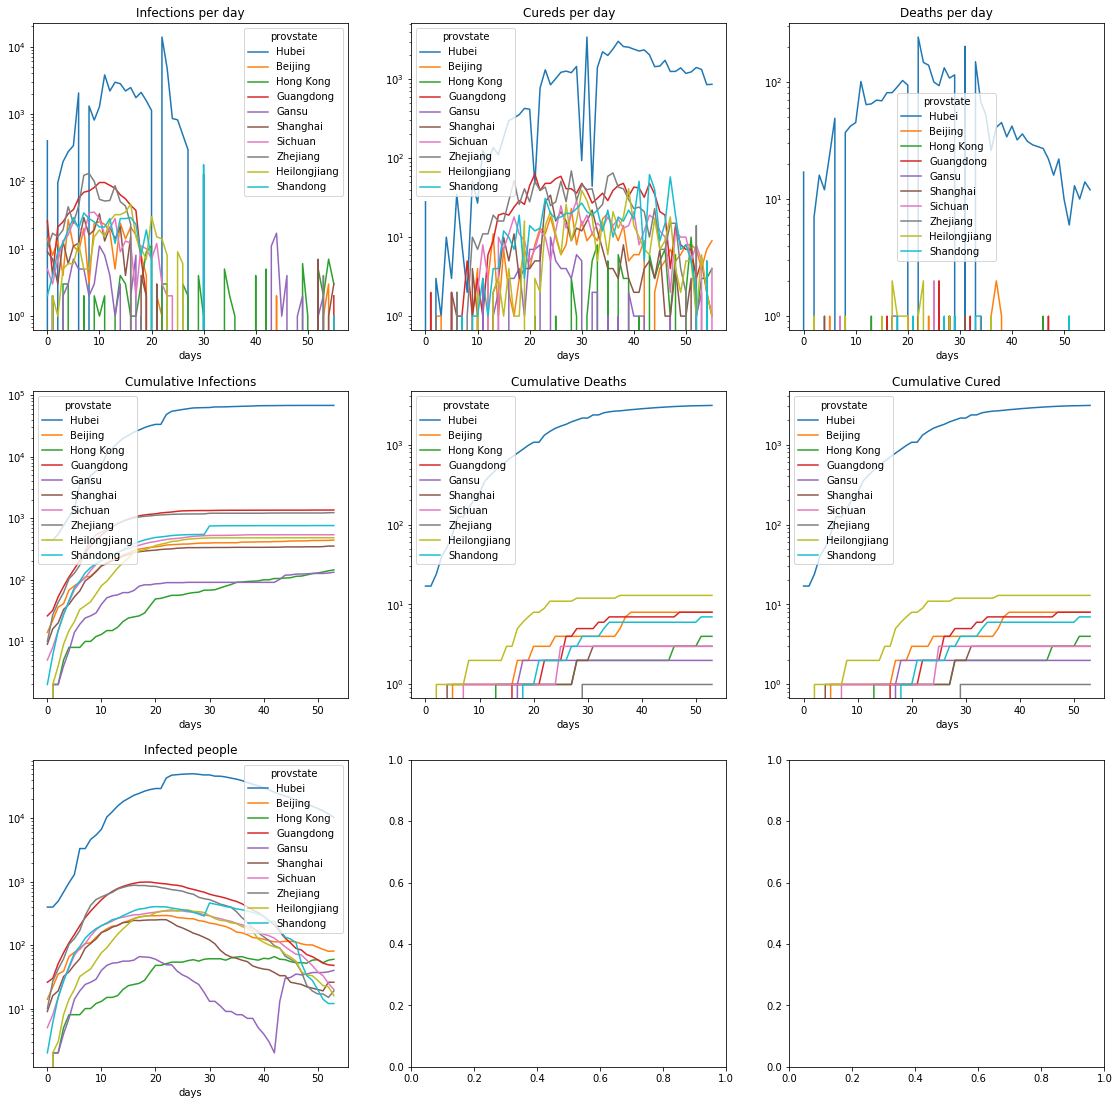

In [15]:
#Most of the cells relating to maxima do not make sense, lets plot the data of infections, deaths and cured for China
china_data_infections_pd=infections_per_day.loc[('China',slice(None))].iloc[:,0:-2]

china_data_infections_pd['mean']=china_data_infections_pd.T.mean()
china_data_infections_pd.sort_values('mean',ascending=False,inplace=True)

china_data_index=china_data_infections_pd.iloc[0:10,:].index#select 10 most affect regions create index

china_data_infections_pd=china_data_infections_pd.loc[china_data_index].T
china_data_infections_pd.drop('mean',inplace=True,axis=0)
dataset_len=len(china_data_infections_pd)
china_data_infections_pd['days']=np.arange(0,dataset_len)
china_data_infections_pd.set_index('days',inplace=True)

china_data_cureds=cureds.loc[('China',slice(None))].iloc[:,0:-2]
china_data_cureds=china_data_cureds.loc[china_data_index].T
dataset_len=len(china_data_cureds)
china_data_cureds['days']=np.arange(0,dataset_len)
china_data_cureds.set_index('days',inplace=True)



china_data_deaths=deaths.loc[('China',slice(None))].iloc[:,0:-2]
china_data_deaths=china_data_deaths.loc[china_data_index].T
dataset_len=len(china_data_deaths)
china_data_deaths['days']=np.arange(0,dataset_len)
china_data_deaths.set_index('days',inplace=True)


china_data_cum_cases=case_cum.loc[('China',slice(None))].iloc[:,0:-2]
china_data_cum_cases=china_data_cum_cases.loc[china_data_index].T
dataset_len=len(china_data_cum_cases)
china_data_cum_cases['days']=np.arange(0,dataset_len)
china_data_cum_cases.set_index('days',inplace=True)

china_data_cum_death=death_cum.loc[('China',slice(None))].iloc[:,0:-2]
china_data_cum_death=china_data_cum_death.loc[china_data_index].T
dataset_len=len(china_data_cum_death)
china_data_cum_death['days']=np.arange(0,dataset_len)
china_data_cum_death.set_index('days',inplace=True)

china_data_cum_cured=cured_cum.loc[('China',slice(None))].iloc[:,0:-2]
china_data_cum_cured=china_data_cum_cured.loc[china_data_index].T
dataset_len=len(china_data_cum_cured)
china_data_cum_cured['days']=np.arange(0,dataset_len)
china_data_cum_cured.set_index('days',inplace=True)

china_data_infected=china_data_cum_cases-china_data_cum_cured-china_data_cum_death


fig,ax=plt.subplots(3,3,figsize=[6.4*3, 4.8*4])

china_data_infections_pd.plot(ax=ax[0,0],logy=True,title='Infections per day');
china_data_cureds.plot(ax=ax[0,1],logy=True,title='Cureds per day');
china_data_deaths.plot(ax=ax[0,2],logy=True,title='Deaths per day');
china_data_cum_cases.plot(ax=ax[1,0],logy=True,title='Cumulative Infections');
china_data_cum_death.plot(ax=ax[1,1],logy=True,title='Cumulative Deaths');
china_data_cum_death.plot(ax=ax[1,2],logy=True,title='Cumulative Cured');
china_data_infected.plot(ax=ax[2,0],logy=True,title='Infected people');


In [16]:
#Also look at the maximum_related data for these top 10 provinces, otherwise look at the plots above

maxima_China_topaff=maxima_rel.loc[('China',slice(None))].loc[china_data_index]
maxima_China_topaff.sort_values('max_infections_per_day',ascending=False)

maxima_China_topaff.iloc[:,4:]

# Allthough plots and data below show meaningful relations in between the maxima the values have to be treated with caution

# one could say that we have normally a peak in infections first, 
#shortly before that or almost at the same time most people die, 
# and the maximum of people cured occurs clearly after. This is not yet visible for most of the provinces

# Also, and this is good news, (if the data is correct) 
# then the number of infections has long passed the time when infections increased exponentially. 
# And the number of infected people seems to already decrease in all worst affected provinces
# This probably means that measures in China proved locally effective
# For the other countries we compare data grouped by countries

# It seems like it takes about 2 weeks from maximum infections rate to peak out of infections (compare to last column)

argmax_infections_per_day argmax_deaths argmax_cureds  \
provstate                                                            
Hubei                       2020-02-13    2020-02-13    2020-02-22   
Beijing                     2020-01-26    2020-02-28    2020-02-19   
Hong Kong                   2020-02-11    2020-02-04    2020-03-13   
Guangdong                   2020-02-01    2020-02-17    2020-02-12   
Gansu                       2020-03-06    2020-02-08    2020-02-15   
Shanghai                    2020-02-01    2020-01-26    2020-02-15   
Sichuan                     2020-01-31    2020-02-16    2020-02-20   
Zhejiang                    2020-01-30    2020-02-20    2020-02-19   
Heilongjiang                2020-02-07    2020-02-08    2020-03-01   
Shandong                    2020-02-21    2020-02-09    2020-03-05   

             argmax_infected days_to_death days_to_cured days_to_max_infected  
provstate                                                                      
Hubei             2020-02-18        0 days        9 days               5 days  
Beijing           2020-02-13       33 days       24 days              18 days  
Hong Kong                NaT       -7 days       31 days                  NaT  
Guangdong         2020-02-10       16 days       11 days               9 days  
Gansu             2020-02-08      -27 days      -20 days             -27 days  
Shanghai          2020-02-12       -6 days       14 days              11 days  
Sichuan           2020-02-15       16 days       20 days              15 days  
Zhejiang          2020-02-07       21 days       20 days               8 days  
Heilongjiang      2020-02-14        1 days       23 days               7 days  
Shandong          2020-02-21      -12 days       13 days               0 days

In [17]:
#now group maxima_rel by countries and also select cumulative values and actual infected persons 
infections_by_country=infections_per_day.iloc[:,:-2].groupby('countryreg').sum()
deaths_by_country=deaths.iloc[:,:-2].groupby('countryreg').sum()
cureds_by_country=cureds.iloc[:,:-2].groupby('countryreg').sum()

cum_case_by_country=case_cum.iloc[:,:-2].groupby('countryreg').sum()
cum_cured_by_country=cured_cum.iloc[:,:-2].groupby('countryreg').sum()
cum_death_by_country=death_cum.iloc[:,:-2].groupby('countryreg').sum()

infected_people_by_country=cum_case_by_country-cum_cured_by_country-cum_death_by_country

maxdate=infections_by_country.iloc[:,0:len(dates)].T.idxmax()
maxdate[maxdate==dates[-1]]=None# Dont allow max to be at the end
maxdate[infections_by_country.iloc[:,0:len(dates)].T.max()==0]=None# Dont allow maximum at 0
maxdate.name='argmax_infections'
maxinfections=infections_by_country.iloc[:,0:len(dates)].T.max()
maxinfections.name='max_infections_per_day'
infections_by_country['maxdate']=maxdate
infections_by_country['maxinfect_per_day']=maxinfections



maxcureddate=cureds_by_country.iloc[:,0:len(dates)].T.idxmax()
maxcureddate[maxcureddate==dates[-1]]=None
maxcureddate[cureds_by_country.iloc[:,0:len(dates)].T.max()==0]=None
maxcureddate.name='argmax_cureds'
maxcured=cureds_by_country.iloc[:,0:len(dates)].T.max()
maxcured.name='max_cureds_per_day'
cureds_by_country['max_cureds_per_day']=maxcured
cureds_by_country['maxcured_date']=maxcureddate


maxdeathdate=deaths_by_country.iloc[:,0:len(dates)].T.idxmax()
maxdeathdate[maxdeathdate==dates[-1]]=None
maxdeathdate[deaths_by_country.iloc[:,0:len(dates)].T.max()==0]=None
maxdeathdate.name='argmax_deaths'
maxdeath=deaths_by_country.iloc[:,0:len(dates)].T.max()
maxdeath.name='max_deaths_per_day'
deaths_by_country['maxdeath_date']=maxdeathdate
deaths_by_country['maxdeath_per_day']=maxdeath

max_infected_date=infected_people_by_country.iloc[:,0:len(dates)].T.idxmax()
max_infected_date[max_infected_date==dates[-1]]=None
max_infected_date[infected_people_by_country.iloc[:,0:len(dates)].T.max()==0]=None
max_infected_date.name='argmax_infected'
max_infected=infected_people_by_country.iloc[:,0:len(dates)].T.max()
max_infected.name='max_of_infected_people'
infected_people_by_country['max_of_infected_people']=max_infected
infected_people_by_country['argmax_infected']=max_infected_date





maxima_rel_by_country=pd.DataFrame(maxinfections)
maxima_rel_by_country['max_deaths_per_day']=maxdeath
maxima_rel_by_country['max_cured_per_day']=maxcured
maxima_rel_by_country['max_of_infected_people']=max_infected
maxima_rel_by_country['argmax_infections']=maxdate
maxima_rel_by_country['argmax_deaths']=maxdeathdate
maxima_rel_by_country['argmax_cureds']=maxcureddate
maxima_rel_by_country['argmax_infected']=max_infected_date
maxima_rel_by_country['avg_days_to_death']=maxdeathdate-maxdate
maxima_rel_by_country['avg_days_to_cured']=maxcureddate-maxdate
maxima_rel_by_country['days_to_max_infected']=max_infected_date-maxdate

maxima_rel_by_country.sort_values('max_infections_per_day',ascending=False);




In [18]:
plot_country_data_infections=infections_by_country.iloc[:,0:-2]
plot_country_data_infections.loc[['Denmark','Finland','Sweden','Norway','Germany','Italy']].T

# Display data from countries of interest

countryreg           Denmark  Finland  Sweden  Norway  Germany   Italy
2020-01-22 00:00:00      0.0      0.0     0.0     0.0      0.0     0.0
2020-01-23 00:00:00      0.0      0.0     0.0     0.0      0.0     0.0
2020-01-24 00:00:00      0.0      0.0     0.0     0.0      0.0     0.0
2020-01-25 00:00:00      0.0      0.0     0.0     0.0      0.0     0.0
2020-01-26 00:00:00      0.0      0.0     0.0     0.0      0.0     0.0
2020-01-27 00:00:00      0.0      0.0     0.0     0.0      1.0     0.0
2020-01-28 00:00:00      0.0      0.0     0.0     0.0      3.0     0.0
2020-01-29 00:00:00      0.0      1.0     0.0     0.0      0.0     0.0
2020-01-30 00:00:00      0.0      0.0     0.0     0.0      0.0     0.0
2020-01-31 00:00:00      0.0      0.0     1.0     0.0      1.0     2.0
2020-02-01 00:00:00      0.0      0.0     0.0     0.0      3.0     0.0
2020-02-02 00:00:00      0.0      0.0     0.0     0.0      2.0     0.0
2020-02-03 00:00:00      0.0      0.0     0.0     0.0      2.0     0.0
2020-02-04 00:00:00      0.0      0.0     0.0     0.0      0.0     0.0
2020-02-05 00:00:00      0.0      0.0     0.0     0.0      0.0     0.0
2020-02-06 00:00:00      0.0      0.0     0.0     0.0      0.0     0.0
2020-02-07 00:00:00      0.0      0.0     0.0     0.0      1.0     1.0
2020-02-08 00:00:00      0.0      0.0     0.0     0.0      0.0     0.0
2020-02-09 00:00:00      0.0      0.0     0.0     0.0      1.0     0.0
2020-02-10 00:00:00      0.0      0.0     0.0     0.0      0.0     0.0
2020-02-11 00:00:00      0.0      0.0     0.0     0.0      2.0     0.0
2020-02-12 00:00:00      0.0     -1.0     0.0     0.0      0.0     0.0
2020-02-13 00:00:00      0.0      0.0     0.0     0.0     -1.0     0.0
2020-02-14 00:00:00      0.0      0.0     0.0     0.0      0.0     0.0
2020-02-15 00:00:00      0.0      0.0     0.0     0.0      0.0     0.0
2020-02-16 00:00:00      0.0      0.0     0.0     0.0      0.0     0.0
2020-02-17 00:00:00      0.0      0.0     0.0     0.0      0.0     0.0
2020-02-18 00:00:00      0.0      0.0     0.0     0.0    -11.0     0.0
2020-02-19 00:00:00      0.0      0.0     0.0     0.0      0.0     0.0
2020-02-20 00:00:00      0.0      0.0     0.0     0.0      0.0     0.0
2020-02-21 00:00:00      0.0      0.0     0.0     0.0     -2.0    16.0
2020-02-22 00:00:00      0.0      0.0     0.0     0.0      0.0    40.0
2020-02-23 00:00:00      0.0      0.0     0.0     0.0      0.0    91.0
2020-02-24 00:00:00      0.0      0.0     0.0     0.0      0.0    71.0
2020-02-25 00:00:00      0.0      0.0     0.0     0.0      1.0    90.0
2020-02-26 00:00:00      0.0      1.0     1.0     1.0      9.0   127.0
2020-02-27 00:00:00      1.0      0.0     5.0     0.0     18.0   155.0
2020-02-28 00:00:00      0.0      0.0     0.0     5.0      2.0   228.0
2020-02-29 00:00:00      2.0      1.0     5.0     9.0     31.0   232.0
2020-03-01 00:00:00      1.0      3.0     2.0     4.0     51.0   524.0
2020-03-02 00:00:00      0.0      0.0     1.0     6.0     29.0   258.0
2020-03-03 00:00:00      2.0      0.0     6.0     7.0     37.0   428.0
2020-03-04 00:00:00      5.0      0.0    14.0    24.0     66.0   443.0
2020-03-05 00:00:00      0.0      6.0    59.0    31.0    220.0   590.0
2020-03-06 00:00:00     12.0      3.0     7.0    21.0    187.0   620.0
2020-03-07 00:00:00      0.0      0.0    60.0    39.0    128.0  1145.0
2020-03-08 00:00:00     13.0      8.0    42.0    29.0    241.0  1326.0
2020-03-09 00:00:00     55.0      7.0    44.0    28.0    134.0  1598.0
2020-03-10 00:00:00    172.0     10.0   107.0   195.0    281.0   809.0
2020-03-11 00:00:00    180.0     19.0   144.0   198.0    443.0  1796.0
2020-03-12 00:00:00    173.0      0.0    99.0   104.0    170.0     0.0
2020-03-13 00:00:00    187.0     96.0   215.0   294.0   1572.0  4365.0
2020-03-14 00:00:00     31.0     70.0   146.0    91.0    908.0  2795.0
2020-03-15 00:00:00     38.0     10.0    60.0   131.0   1208.0  2853.0
2020-03-16 00:00:00     56.0     33.0    78.0   112.0   1450.0  2470.0
2020-03-17 00:00:00     

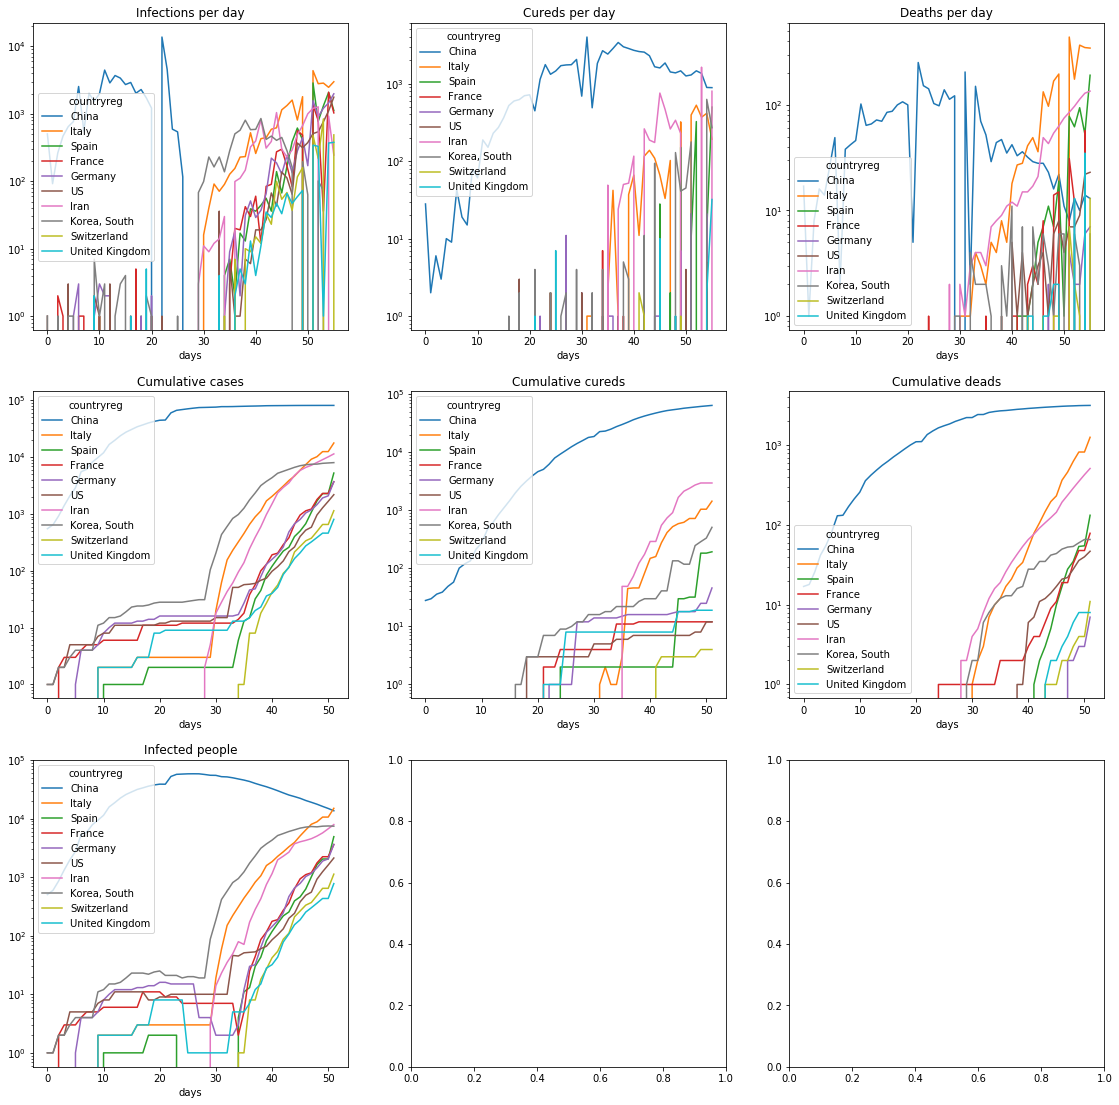

In [19]:

plot_country_data_infections['max']=plot_country_data_infections.T.max()
plot_country_data_infections.sort_values('max',ascending=False,inplace=True)
data_index=plot_country_data_infections.iloc[0:10,:].index#select 10 most affect regions create index
plot_country_data_infections=plot_country_data_infections.loc[data_index].T
plot_country_data_infections.drop('max',inplace=True,axis=0)
dataset_len=len(plot_country_data_infections)
plot_country_data_infections['days']=np.arange(0,dataset_len)
plot_country_data_infections.set_index('days',inplace=True)

plot_country_data_cureds=cureds_by_country.iloc[:,0:-2]
plot_country_data_cureds=plot_country_data_cureds.loc[data_index].T
dataset_len=len(plot_country_data_cureds)
plot_country_data_cureds['days']=np.arange(0,dataset_len)
plot_country_data_cureds.set_index('days',inplace=True)

plot_country_data_deaths=deaths_by_country.iloc[:,0:-2]
plot_country_data_deaths=plot_country_data_deaths.loc[data_index].T
dataset_len=len(plot_country_data_deaths)
plot_country_data_deaths['days']=np.arange(0,dataset_len)
plot_country_data_deaths.set_index('days',inplace=True)





plot_country_data_cum_case=cum_case_by_country.iloc[:,0:-2]
plot_country_data_cum_case=plot_country_data_cum_case.loc[data_index].T
dataset_len=len(plot_country_data_cum_case)
plot_country_data_cum_case['days']=np.arange(0,dataset_len)
plot_country_data_cum_case.set_index('days',inplace=True)

plot_country_data_cum_cured=cum_cured_by_country.iloc[:,0:-2]
plot_country_data_cum_cured=plot_country_data_cum_cured.loc[data_index].T
dataset_len=len(plot_country_data_cum_cured)
plot_country_data_cum_cured['days']=np.arange(0,dataset_len)
plot_country_data_cum_cured.set_index('days',inplace=True)


plot_country_data_cum_death=cum_death_by_country.iloc[:,0:-2]
plot_country_data_cum_death=plot_country_data_cum_death.loc[data_index].T
dataset_len=len(plot_country_data_cum_death)
plot_country_data_cum_death['days']=np.arange(0,dataset_len)
plot_country_data_cum_death.set_index('days',inplace=True)

plot_country_data_infected=plot_country_data_cum_case-plot_country_data_cum_cured-plot_country_data_cum_death


fig,ax=plt.subplots(3,3,figsize=[6.4*3, 4.8*4])

plot_country_data_infections.plot(ax=ax[0,0],logy=True,title='Infections per day');
plot_country_data_cureds.plot(ax=ax[0,1],logy=True,title='Cureds per day');
plot_country_data_deaths.plot(ax=ax[0,2],logy=True,title='Deaths per day');
plot_country_data_cum_case.plot(ax=ax[1,0],logy=True,title='Cumulative cases');
plot_country_data_cum_cured.plot(ax=ax[1,1],logy=True,title='Cumulative cureds');
plot_country_data_cum_death.plot(ax=ax[1,2],logy=True,title='Cumulative deads');
plot_country_data_infected.plot(ax=ax[2,0],logy=True,title='Infected people');







In [20]:
#Also look at the maximum_related data for these top 10 countries below

maxima_world_topaff=maxima_rel_by_country.loc[data_index]
maxima_world_topaff.sort_values('max_infections_per_day',ascending=False)
maxima_world_topaff.iloc[:,4:]

#Here we see a completely different story. 
#Whilst infections maxed out in China already, this is still to happen with  the other countries,
# as dead or recoverd numbers have not yeet significant influence

#Next best "inflection" of infection rates towards a max out shows South Korea.

#The data related to cured rates are non conclusive since too low for other countries
#Though for Iran high rates of recovery have been reported

#The death toll is so far still highest in China,
# but the death rates have allready peaked out, according to the reported data.
# For Iran and esepcially for Italy the death rates are increasing and soon death rates will be higher 
# than they have ever been in China.

# For the high amount of infections South Korea has very low amount of deaths and as it seems recovering

#Interesting is also that there seem to be cases in which infections first stall 
#and then after some time to rapidly increase again. These might be due to local differences
# and due to the virus having managed to spread elsewhere in the country


#EDIT 15.03.2020 Data has changed maybe above comments are obsolete now. 
# Anyway from Chinese and South Korean data one could conclude that death rate is maximum
# at the same time with the maximum rate of infections (indicating health care resource shortage influences)
# Also, it looks like 10 days after the maximum rate of new infections the maximum of infected people is reached
# And that it takes 4 respective 10 days to be declared as cured ... ? Not obvious assumption do not seem to hold

argmax_infections argmax_deaths argmax_cureds argmax_infected  \
countryreg                                                                     
China                 2020-02-13    2020-02-13    2020-02-22      2020-02-17   
Italy                 2020-03-13    2020-03-13    2020-03-14      2020-03-15   
Spain                 2020-03-13           NaT           NaT      2020-03-15   
France                2020-03-16    2020-03-16    2020-02-25      2020-03-15   
Germany                      NaT           NaT    2020-03-13      2020-03-15   
US                           NaT           NaT    2020-03-16      2020-03-15   
Iran                  2020-03-14           NaT    2020-03-15      2020-03-14   
Korea, South          2020-03-03    2020-03-02    2020-03-16      2020-03-15   
Switzerland           2020-03-15           NaT    2020-03-03      2020-03-15   
United Kingdom               NaT    2020-03-16           NaT      2020-03-15   

               avg_days_to_death avg_days_to_cured days_to_max_infected  
countryreg                                                               
China                     0 days            9 days               4 days  
Italy                     0 days            1 days               2 days  
Spain                        NaT               NaT               2 days  
France                    0 days          -20 days              -1 days  
Germany                      NaT               NaT                  NaT  
US                           NaT               NaT                  NaT  
Iran                         NaT            1 days               0 days  
Korea, South             -1 days           13 days              12 days  
Switzerland                  NaT          -12 days               0 days  
United Kingdom               NaT               NaT                  NaT

In [21]:
#Now I switch to data from italy, as they are reliable and available on a provincew level

data_italy_regions = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv')
data_italy_provinces=pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv')
data_italy_provinces['prov_code']=data_italy_provinces.codice_provincia
data_italy_provinces.set_index(['prov_code','data'],inplace=True)
data_italy_provinces.sort_values(['codice_provincia','data'],inplace=True)
data_italy_provinces.loc[data_italy_provinces.codice_provincia==63,'sigla_provincia']='NA'
#data_italy_provinces

#reformating
data_italy_row=data_italy_provinces.loc[(1,slice(None))].reset_index().iloc[0:1,1:-1]
case_data=data_italy_provinces.loc[(1,slice(None))].iloc[:,-1:].T.reset_index().drop('index',axis=1)
data_italy_prov=pd.concat([data_italy_row,case_data],sort=False,axis=1)
#data_italy_prov
for provinces in data_italy_provinces.index.levels[0][1:]:
    data_italy_row=data_italy_provinces.loc[(provinces,slice(None))].reset_index().iloc[0:1,1:-1]
    case_data= data_italy_provinces.loc[(provinces,slice(None))].iloc[:,-1:].T.reset_index().drop('index',axis=1)
    data_italy_row=pd.concat([data_italy_row,case_data],sort=False,axis=1)
    data_italy_prov=pd.concat([data_italy_prov,data_italy_row],sort=False,axis=0)

data_italy_prov=data_italy_prov.reset_index().drop(['index'],axis=1).set_index(['codice_regione','codice_provincia'])
data_italy_prov.sort_values(['codice_regione','codice_provincia'],inplace=True)
#data_italy_prov


#load map of italy

gdf = gpd.read_file('./ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp')

gdf['country']=gdf.adm1_code.str.split('-').str[0]
gdf['reg_code']=gdf.adm1_code.str.split('-').str[1]
gdf.set_index(['country','reg_code'],inplace=True)
gdf.sort_values(['country','reg_code'],inplace=True)
map_italy=gdf.loc[('ITA',slice(None))]

#prepare for join
map_italy['sigla_provincia']=map_italy['iso_3166_2'].str.split('-').str[1]
map_italy=map_italy.loc[:,['sigla_provincia','geometry']]

#https://hri.fi/data/en_GB/dataset/auringon-sateilyenergian-maara-katoilla-paakaupunkiseudulla

#load extra data on provinces from wikipedia
province_data_italy=pd.read_html('https://en.wikipedia.org/wiki/Provinces_of_Italy')[2]

province_data_italy=province_data_italy.iloc[1:-1,:]
province_data_italy.Population=pd.to_numeric(province_data_italy.Population)/1.0
province_data_italy['Area (km²)']=pd.to_numeric(province_data_italy['Area (km²)'])/1.0
province_data_italy['Density (/km²)']=pd.to_numeric(province_data_italy['Density (/km²)'])/1.0
province_data_italy=province_data_italy.rename(columns={'ISOcode':'sigla_provincia'})
province_data_italy.loc[province_data_italy.Capital=='Naples','sigla_provincia']='NA'

# Now start to merge. First map with province data
map_italy=map_italy.merge(province_data_italy,'right','sigla_provincia')

#second merge with data from provinces
data_italy_prov=data_italy_prov.drop(['stato','lat','long'],axis=1).iloc[:,2:]
merge_map_italy=map_italy.merge(data_italy_prov,'left','sigla_provincia').set_index('Province')
data_columns_name_first='2020-02-24 18:00:00'


In [22]:
data_italy_prov


sigla_provincia  2020-02-24 18:00:00  \
codice_regione codice_provincia                                        
1              1                             TO                    0   
               2                             VC                    0   
               3                             NO                    0   
               4                             CN                    0   
               5                             AT                    0   
...                                         ...                  ...   
20             91                            NU                    0   
               92                            CA                    0   
               95                            OR                    0   
               111                           SU                    0   
               993                          NaN                    0   

                                 2020-02-25 18:00:00  2020-02-26 18:00:00  \
codice_regione codice_provincia                                             
1              1                                   3                    3   
               2                                   0                    0   
               3                                   0                    0   
               4                                   0                    0   
               5                                   0                    0   
...                                              ...                  ...   
20             91                                  0                    0   
               92                                  0                    0   
               95                                  0                    0   
               111                                 0                    0   
               993                                 0                    0   

                                 2020-02-27 18:00:00  2020-02-28 18:00:00  \
codice_regione codice_provincia                                             
1              1                                   2                   11   
               2                                   0                    0   
               3                                   0                    0   
               4                                   0                    0   
               5                                   0                    0   
...                                              ...                  ...   
20             91                                  0                    0   
               92                                  0                    0   
               95                                  0                    0   
               111                                 0                    0   
               993                                 0                    0   

                                 2020-02-29 17:00:00  2020-03-01 17:00:00  \
codice_regione codice_provincia                                             
1              1                                  11                   49   
               2                                   0                    0   
               3                                   0                    0   
               4                                   0                    0   
               5                                   0                    0   
...                                              ...                  ...   
20             91                                  0                    0   
               92                                  0                    0   
               95                                  0                    0   
               111                                 0                    0   
               993                                 0                    0   

                                 2020-03-02 17:00:00  2020-03-03 17:00:00  \
codice_regio

In [23]:
from matplotlib import colors

data_columns=merge_map_italy.loc[:,data_columns_name_first:].columns.values
n_data=len(data_columns)

maxval=merge_map_italy.loc[:,data_columns_name_first:].max().values.max()
digs=10**np.floor(np.log10(maxval))

print('Maximum cases : ',maxval)

vmin=1
vmax=(maxval//digs+1)*1000

print(n_data,end=' ')

fig=plt.figure()
for i in range(n_data):
    print(i,end=' ')
    data_column = data_columns[i]    
    ax=fig.add_subplot(111);
    ax=merge_map_italy.plot(column=data_column,ax=ax,cmap='rainbow',linewidth=1, edgecolor='0.5', vmin=vmin, vmax=vmax,
legend=True, norm=colors.LogNorm(vmin=vmin, vmax=vmax));
    ax.set_title('Total cases '+data_column);
    plt.gcf().savefig(f'test{i:02}.png', bbox_inches='tight', dpi=400);
    plt.clf();
 

#https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html

Maximum cases :  3993
23 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

<Figure size 432x288 with 0 Axes>

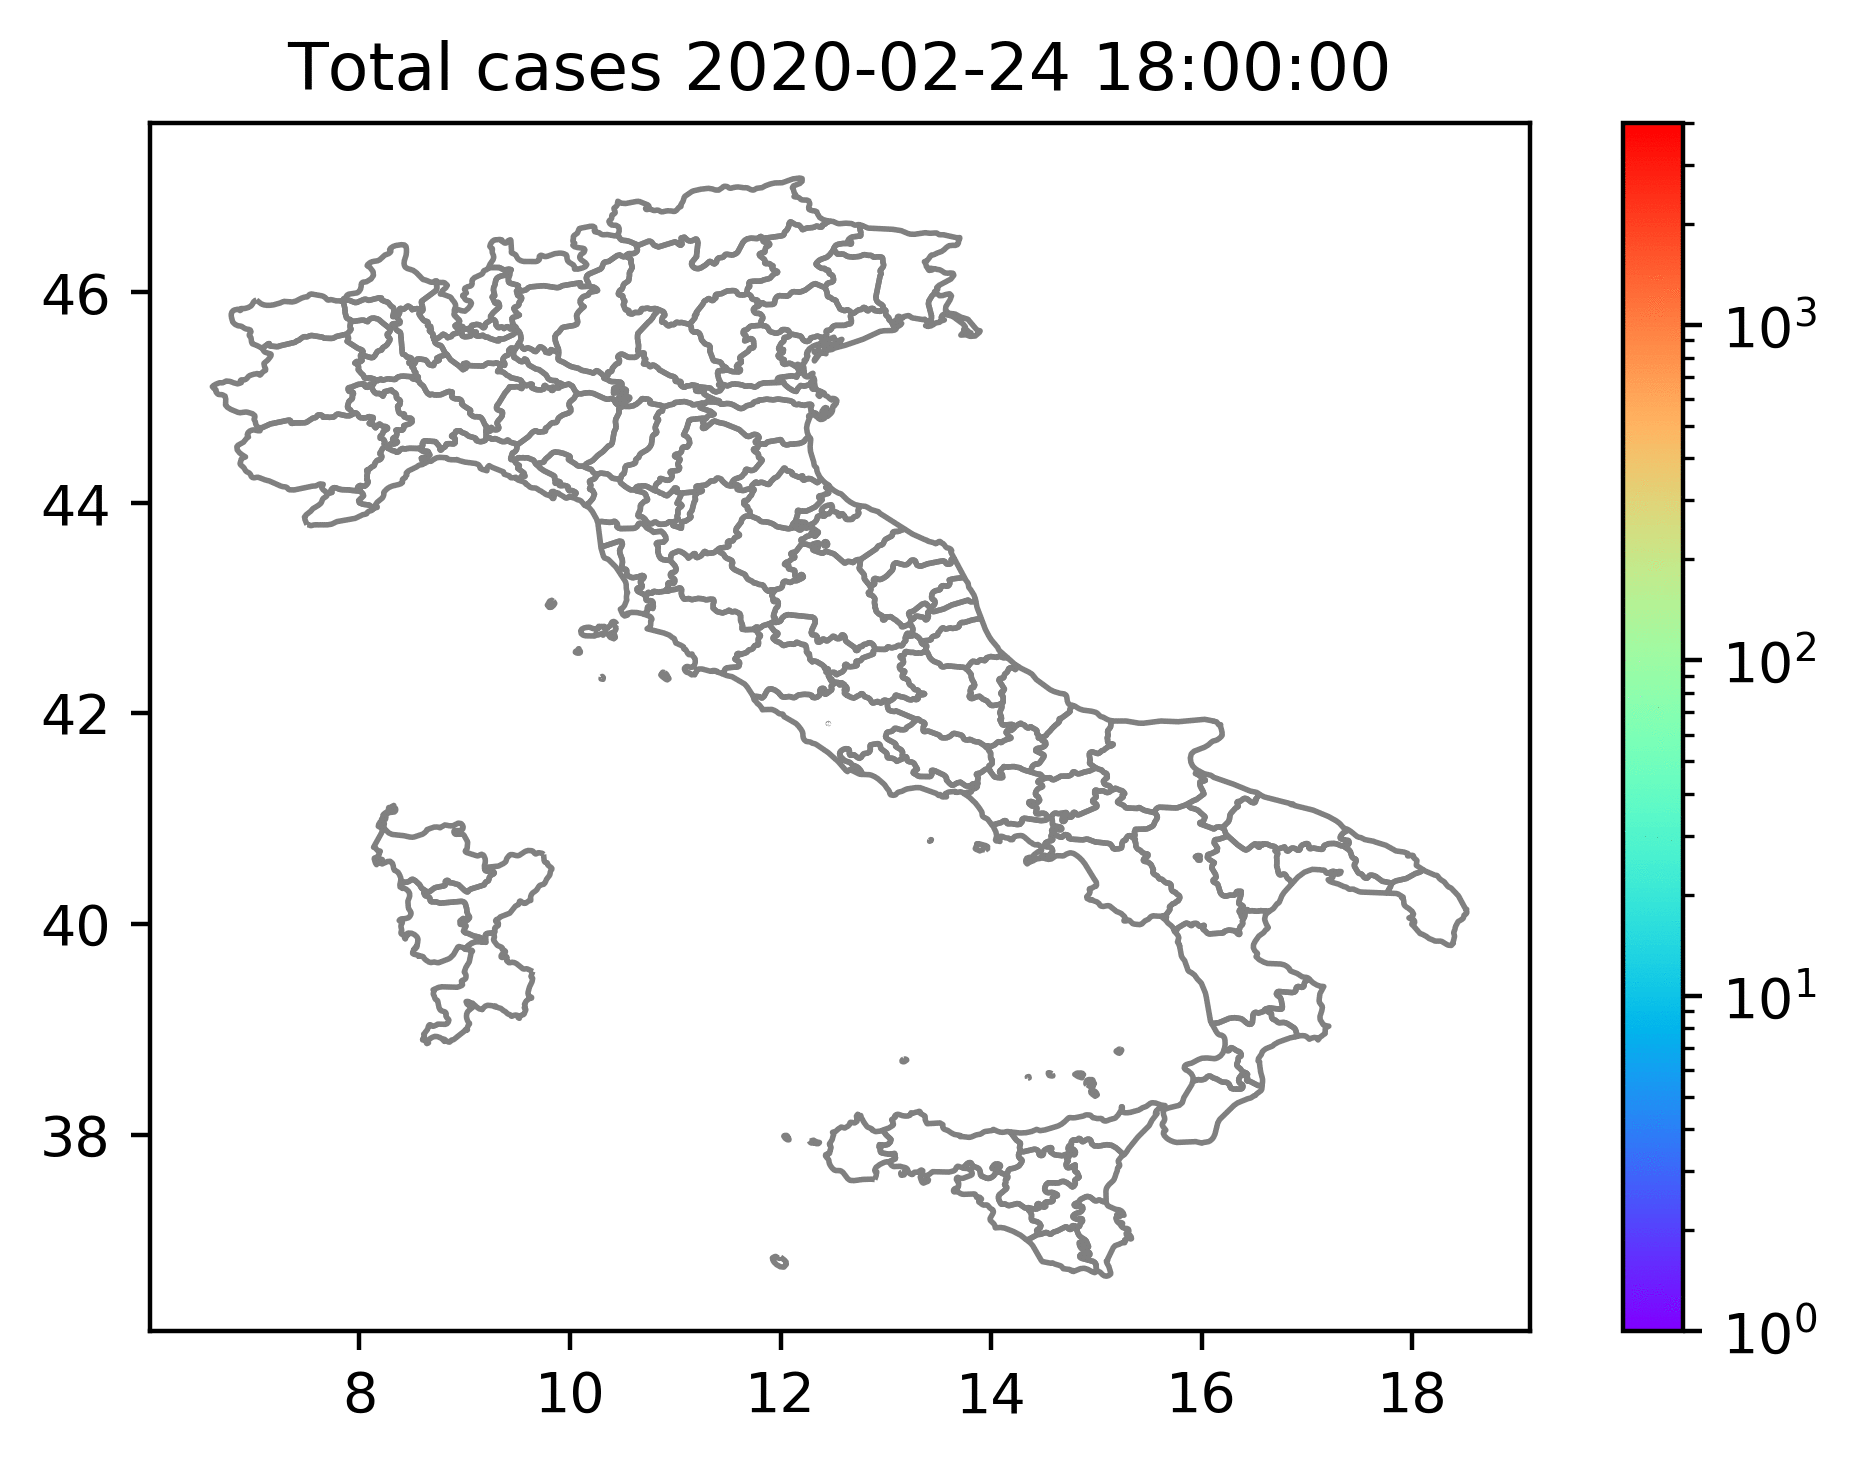

In [24]:
!magick convert -delay 100 -loop 0 test*.png Italy_animated_map.gif

from IPython.display import Image;
Image("Italy_animated_map.gif")

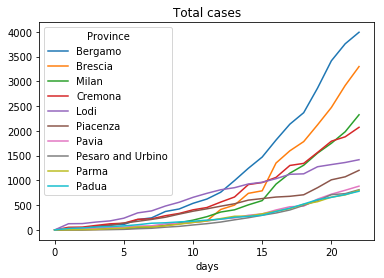

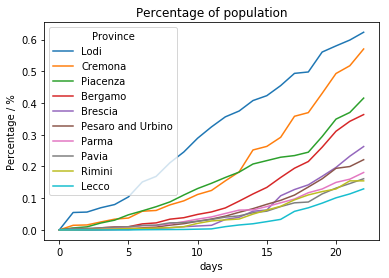

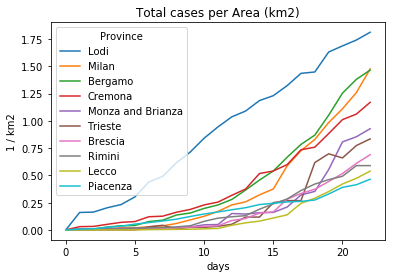

In [26]:
Data=merge_map_italy.sort_values(merge_map_italy.columns[-1],ascending=False)
Data=Data.loc[:,data_columns_name_first:].iloc[0:10,:].T
Data['days']=np.arange(len(Data))
ax=pd.DataFrame(Data).plot(title='Total cases',x='days')
ax.set_xlabel('days');

#First plot worst affected provinces in absolute numbers

#then divide by population and look at the percentages

merge_map_italy_percentage=merge_map_italy.copy()
for column in merge_map_italy.loc[:,data_columns_name_first:].columns:
    merge_map_italy_percentage[column]=merge_map_italy_percentage[column]/pd.to_numeric(merge_map_italy_percentage.Population)

Data=merge_map_italy_percentage.sort_values(merge_map_italy_percentage.columns[-1],ascending=False)
Data=Data.loc[:,data_columns_name_first:].iloc[0:10,:].T*100
Data['days']=np.arange(len(Data))
ax=pd.DataFrame(Data).plot(title='Percentage of population',x='days');
ax.set_xlabel('days');
ax.set_ylabel('Percentage / %');


# Also look at the number of cases per area

merge_map_italy_per_area=merge_map_italy.copy()
for column in merge_map_italy.loc[:,data_columns_name_first:].columns:
    merge_map_italy_per_area[column]=merge_map_italy_per_area[column]/pd.to_numeric(merge_map_italy_per_area['Area (km²)'])

Data=merge_map_italy_per_area.sort_values(merge_map_italy_per_area.columns[-1],ascending=False)
Data=Data.loc[:,data_columns_name_first:].iloc[0:10,:].T
Data['days']=np.arange(len(Data))
ax=pd.DataFrame(Data).plot(title='Total cases per Area (km2)',x='days');
ax.set_xlabel('days');
ax.set_ylabel('1 / km2');


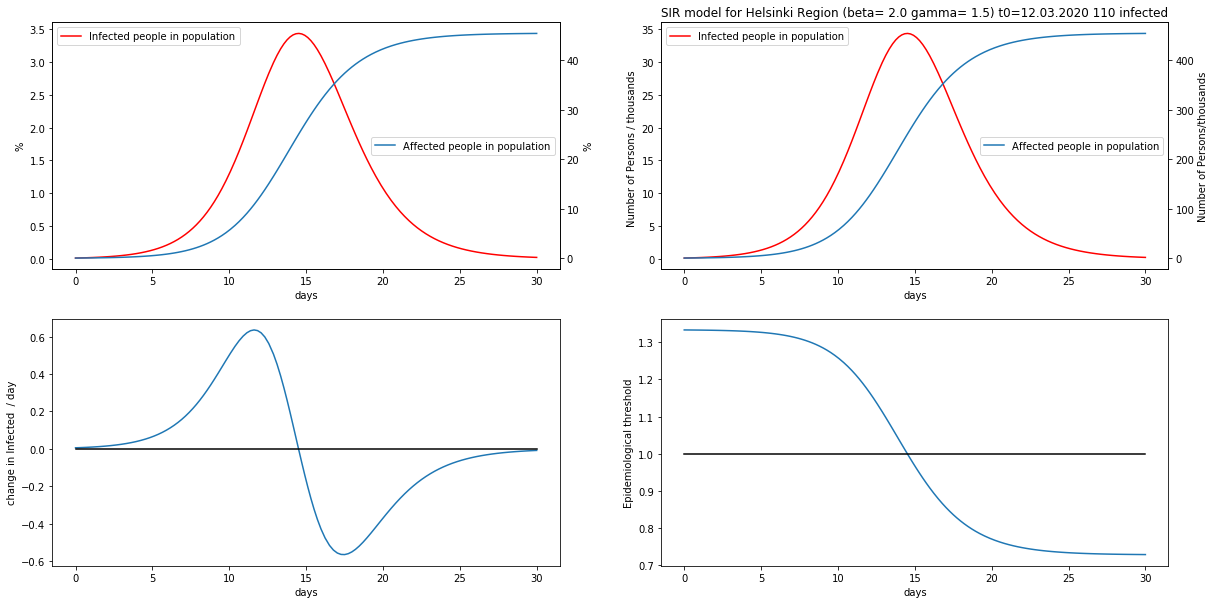

In [27]:
#Now I want to start modelling a simple SIR model where only S and I are modelled

from scipy.integrate import solve_ivp
def SIR_model_without_R(t, y,beta,gamma):
    S=y[0]
    I=y[1]
    dSdt=-beta*I*S
    dIdt=beta*I*S-gamma*I    
    return [dSdt,dIdt]

beta=2.0
gamma=1.5

sol = solve_ivp(lambda t,y: SIR_model_without_R(t,y,beta,gamma), [0, 30],(1,110/1e6),teval=np.arange(0,30,1),rtol=1e-10,atol=1e-10)
fig,ax=plt.subplots(2,2,figsize=[20,10]);
S=sol.y[0,:]
I=sol.y[1,:]
ax[0,0].plot(sol.t,I*100,'r-',label='Infected people in population')
ax[0,0].set_xlabel('days')
ax[0,0].set_ylabel('%')

ax2=ax[0,0].twinx()
ax2.plot(sol.t,100-S*100,'-',label='Affected people in population')
ax[0,0].legend(loc=2)
ax2.legend(loc=7)
ax2.set_ylabel('%')

ax[1,1].plot(sol.t,S*beta/gamma,'-',sol.t,np.ones(sol.t.shape),'k-')
ax[1,1].set_xlabel('days')
ax[1,1].set_ylabel('Epidemiological threshold')

ax[1,0].plot(sol.t,100*beta*I*S-100*gamma*I,'-',sol.t,np.zeros(sol.t.shape),'k-')
ax[1,0].set_xlabel('days');
ax[1,0].set_ylabel('change in Infected  / day');



ax[0,1].plot(sol.t,I*1e3,'r-',label='Infected people in population')
ax[0,1].set_xlabel('days')
ax[0,1].set_ylabel('Number of Persons / thousands ')
ax[0,1].set_title(f'SIR model for Helsinki Region (beta= {beta} gamma= {gamma}) t0=12.03.2020 110 infected')

ax3=ax[0,1].twinx()
ax3.plot(sol.t,1e3-S*1e3,'-',label='Affected people in population')
ax[0,1].legend(loc=2);
ax3.legend(loc=7);
ax3.set_ylabel('Number of Persons/thousands');

# This SIR model is simulated first, where parameters were adjusted such, that the curves look similar 
# than above curves and have comparible time characteristics. 
# Also, the paramters were chosen such that 40-60% of the population was affected in the end
# (as it was suggested in media)

#This simulation suggests that it will take from totday on about 2 two 3 weeks until worst is over
#Also, that at the top about 3-4% of the population will be infected at the same time.


In [28]:
from scipy.optimize import minimize
from lmfit import Model



# Make an objective function for optimization of italian data to SIR model
def SIR_model_without_R(t, y,beta,gamma,N):
    S=y[0]
    I=y[1]
    Icum=y[2]
    dSdt=-beta*I*S/N
    dIdt=beta*I*S/N-gamma*I
    dIcumdt=beta*I*S/N
    return [dSdt,dIdt,dIcumdt]

def fit_function(t,beta,gamma,S0,I0,N):
    sol= solve_ivp(lambda t,y: SIR_model_without_R(t,y,beta,gamma,N), 
                   [0, max(t)],(S0,I0,I0),teval=np.arange(0,max(t),1e-3),
                   dense_output=True,rtol=1e-10,atol=1e-20)
    y=sol.sol(t)
    return y[2]

def model_function(t,beta,gamma,S0,I0,N):

    sol= solve_ivp(lambda t,y: SIR_model_without_R(t,y,beta,gamma,N), 
                   [0, max(t)],(S0,I0,I0),teval=np.arange(0,max(t),1e-3),
                   dense_output=True,rtol=1e-10,atol=1e-20)
    y=sol.sol(t)
    return y


fit_Data=merge_map_italy.copy().loc[:,data_columns_name_first:]
last_column=fit_Data.columns[-1]
fit_Data=fit_Data.join(pd.DataFrame(merge_map_italy.Population))
fit_Data=fit_Data.sort_values(last_column,ascending=False).loc[:,data_columns_name_first:]


cum_model = Model(fit_function)
cum_model.set_param_hint('beta',value=6,min=0,vary=True)
cum_model.set_param_hint('gamma',value=6,min=0,vary=True)
cum_model.set_param_hint('S0',min=0,vary=False)
cum_model.set_param_hint('I0',min=0,vary=False)
cum_model.set_param_hint('N',min=0,vary=False)
params1 = cum_model.make_params()

complete_model = Model(model_function)
complete_model.set_param_hint('beta',value=6,min=0,vary=True)
complete_model.set_param_hint('gamma',value=5.8,min=0,vary=True)
complete_model.set_param_hint('S0',min=0,vary=False)
complete_model.set_param_hint('I0',min=0,vary=False)
complete_model.set_param_hint('N',min=0,vary=False)
params2 = complete_model.make_params()


In [29]:
import time
from lmfit.model import save_modelresult
from lmfit.model import load_modelresult
from pathlib import Path
    

def fit_model(gmodel,gmodel_2,Data,t,S0,I0,N,title1,title2,ax):
    result=gmodel.fit(Data,t=t,S0=N,I0=Data[0],N=N)
    #print(result.fit_report())
    tnew=np.arange(60)
    best_fit=gmodel.eval(t=tnew,beta=result.values['beta'],gamma=result.values['gamma'],S0=N,I0=Data[0],N=N)
    
    
    del_fit = result.eval_uncertainty(t=tnew)
    upper_band=best_fit+del_fit
    lower_band=best_fit-del_fit
    ax[0].plot(t, Data, 'bo',label='Data')
    ax[0].plot(tnew, best_fit, 'r-', label='best fit SIR model')
    ax[0].plot(tnew,upper_band, 'k-', label='conf bands')
    ax[0].plot(tnew,lower_band,'k-')
    ax[0].legend(loc='best',fontsize=18)
    ax[0].set_title(title1,fontsize=20)
    ax[0].set_xlabel('time/days',fontsize=18)
    ax[0].set_ylabel('Total infected persons',fontsize=18)
    plt.setp(ax[0].get_yticklabels(),fontsize=16)
    plt.setp(ax[0].get_xticklabels(),fontsize=16)
        
    tnew2=np.arange(0,60,0.01)    
    best_SI=gmodel_2.eval(t=tnew2,beta=result.values['beta'],gamma=result.values['gamma'],S0=N,I0=Data[0],N=N)
    ax[1].plot(tnew2,best_SI[1].T/N*100,'k-')
    ax[2].plot(tnew2,best_SI[0].T/N*100)
    ax[1].set_xlabel('time/days',fontsize=18)
    ax[1].set_ylabel('I (infected persons) / %',fontsize=18)
    ax[1].set_title(title2,fontsize=20)    
    ax[2].set_ylabel('S (Not infected persons) / %',fontsize=18)
    plt.setp(ax[1].get_yticklabels(),fontsize=16)
    plt.setp(ax[1].get_xticklabels(),fontsize=16)
    plt.setp(ax[2].get_yticklabels(),fontsize=16)
    
    Data_plot=pd.DataFrame({'t':t,'Data':Data})
    best_fit=pd.DataFrame({'t':tnew,'best_fit':best_fit})
    upper=pd.DataFrame({'t':tnew,'upper_band':upper_band})
    lower=pd.DataFrame({'t':tnew,'lower_band':lower_band})
    best_fit_S=pd.DataFrame({'t':tnew2,'best_fit_S':best_SI[0].T})
    best_fit_I=pd.DataFrame({'t':tnew2,'best_fit_I':best_SI[1].T})
    
    return result,Data_plot,best_fit,upper,lower,best_fit_S,best_fit_I





provinces=fit_Data.index

fig,ax=plt.subplots(1,2,figsize=[20,10])    
ax2=ax[1].twinx()
ax=[ax[0],ax[1],ax2]
print(len(fit_Data),end=' ')

fit_result_Data=pd.DataFrame({'lmfit_result_files':[],'Data_plots':[],'best_fits':[],
                       'upper':[],'lower':[],'best_fit_S':[],'best_fit_I':[]})
update= True
try:
    if not(update):
        fit_result_Data=pd.read_json('Italy_SIR_fit.json')
except:
    pass
for n in range(len(fit_Data)):
    print(n,end='')
    if (n<len(fit_result_Data)):
        if fit_result_Data.loc[n][0]!=None:
            print('r',end=' ')
            continue
    Data=fit_Data.iloc[n,:-1].values
    N=fit_Data.iloc[n,-1]
    if max(Data)>1:
        while Data[0]<=0:
            Data=Data[1:]
    else:
        fit_result_Data.loc[n]=[None,None,None,None,None,None,None]
        continue
    t=np.arange(len(Data))
    S0=N
    I0=Data[0]
    try:
        result,Data_plot,best_fit,upper,lower,best_fit_S,best_fit_I=fit_model(cum_model,complete_model,Data,t,S0,I0,N,f'Cumulative infections in {provinces[n]}',f'S and I {provinces[n]}',ax);
        print('s',end='')
        #save result to separate file
        result_file=f'Italy_SIR_fitresult_{n:003}_{provinces[n]}.sav'
        save_modelresult(result,result_file)
    
        #save figure to png
        
        if (Path(f'Italy_SIR_fit_{n:003}_{provinces[n]}.png').is_file())and not(update):
            print ('x',end=' ')
        else:
            fig.savefig(f'Italy_SIR_fit_{n:003}_{provinces[n]}.png', bbox_inches='tight', dpi=400);
            print ('w',end=' ')
        fit_result_Data.loc[n]=[result_file,Data_plot,best_fit,upper,lower,best_fit_S,best_fit_I]
        #plt.show()
    except:
        fit_result_Data.loc[n]=[None,None,None,None,None,None,None]
    #time.sleep(2)
    ax[0].clear();
    ax[1].clear();
    ax[2].clear(); 

fig.clf()
fit_result_Data.to_json('Italy_SIR_fit.json')

106 0sw 1sw 2sw 3sw 4sw 5sw 6sw 7sw 8sw 9sw 10sw 11sw 12sw 13sw 14sw 15sw 16sw 17sw 18sw 19sw 20sw 21sw 22sw 23sw 24sw 25sw 26sw 27sw 28sw 29sw 30sw 31sw 32sw 33sw 3435sw 36sw 37sw 38sw 39sw 40sw 41sw 42sw 43sw 44sw 45sw 46sw 47sw 48sw 49sw 50sw 5152sw 53sw 5455sw 5657sw 58sw 596061sw 62sw 63sw 64sw 65sw 66sw 67sw 68sw 69sw 70sw 71sw 72sw 73sw 74sw 7576sw 7778sw 79sw 80sw 81sw 82sw 83sw 84sw 85sw 8687sw 88sw 89sw 90sw 9192sw 93sw 94sw 95sw 96sw 9798sw 99100101102sw 103104sw 105

<Figure size 1440x720 with 0 Axes>

In [ ]:
result.params['beta']/result.params['gamma']

In [ ]:



!magick convert -delay 2000 -loop 0 Italy_SIR_fit_00*.png Italy_SIR_fit_animated.gif

from IPython.display import Image;
Image('Italy_SIR_fit_animated.gif')

#The italian regional data was fitted to a SIR model with lmfit. 10 example figures were animated
# and show the very different qualities of the fits. However, the Data seems to suggest 
# that about 4-6% of the population in Italy will be affected, which is much lower than the predicted 40-60%.
# The model does not include any second wave effects, where it is unshure however, if they could occur
# (For example if infection rates would be increased compared to the first wave due to carelessness)

# Data also suggests that typically maxima of infections are reached 30 days after recording started (soon)
# And that after 2 months the 1st wave is over

In [ ]:
# Now lets still display the basic reproduction number for all provinces
merge_map_italy_fit_results=pd.DataFrame(merge_map_italy.copy())
merge_map_italy_fit_results['beta']=None
merge_map_italy_fit_results['gamma']=None

for n in range(len(fit_result_Data)):
    result_file=fit_result_Data.iloc[n,:].lmfit_result_files
    if not(pd.isnull(result_file)):
        result=load_modelresult(result_file)
        if result.params['beta'].stderr/result.params['beta']<1:# include only reasonable fits
            merge_map_italy_fit_results.iloc[n,-2]=result.params['beta'].value
            merge_map_italy_fit_results.iloc[n,-1]=result.params['gamma'].value
        
merge_map_italy_fit_results['R0']=pd.to_numeric(merge_map_italy_fit_results['beta']/merge_map_italy_fit_results['gamma'])
merge_map_italy_fit_results['beta']=pd.to_numeric(merge_map_italy_fit_results['beta'])
merge_map_italy_fit_results['gamma']=pd.to_numeric(merge_map_italy_fit_results['gamma'])


merge_map_italy_fit_results.plot(y='R0',kind='hist')
merge_map_italy_fit_results.plot(x='Density (/km²)',y='R0',kind='scatter')
merge_map_italy_fit_results.plot(x='Population',y='R0',kind='scatter')

merge_map_italy_fit_corr=merge_map_italy_fit_results.copy()
columns=merge_map_italy_fit_corr.columns
#print(columns[9:-3])
merge_map_italy_fit_corr=merge_map_italy_fit_corr.drop(columns[9:-3],axis=1)
merge_map_italy_fit_corr=merge_map_italy_fit_corr.drop(columns[0:6],axis=1)

merge_map_italy_fit_corr.dropna().corr()

#Basic reproduction number is only in the order of 1 to 1.03 for reasonable fits
#And does not really depend on population density
#though a little on Area and population. It is logic that more Area refers to low reproduction rates,
#but unlogic that it would be lower for higher population (Maybe an effect of better isolation praxis??)
#anyhow, infection rates beta follow logic trends, except for Area 



In [ ]:
# load geopandas
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

#fig,ax=plt.subplots(1,figsize=(20,20))

#world.plot(ax=ax,cmap='jet')
#cities.plot(ax=ax)

#print(world_newindes)#''.loc[('America',slice(None))])

#countries_in_gpd=world.name

In [ ]:
#gdf = gpd.read_file('./ne_10m_admin_1_states_provinces_scale_rank/ne_10m_admin_1_states_provinces_scale_rank.shp')
#gdf['country']=gdf.adm1_code.str.split('-').str[0]
#gdf['reg_code']=gdf.adm1_code.str.split('-').str[1]
#gdf.set_index(['country','name'],inplace=True)
#gdf.sort_values(['country','name'],inplace=True)
#gdf.loc[('DEU',slice(None))]

In [ ]:
#countries_in_data=cum_case_by_country.index.unique().values
#Now check if they can be matched with geopandas worldmap
#I built this up sequentially as done in https://www.youtube.com/watch?v=cxLht5KN3pQ

#data_countries_in_geopandas={}
#for country in countries_in_data:
#    if country in list(world.name):
#        data_countries_in_geopandas[country]=country
#    elif country=='Singapore':
#        pass
#    elif country=='USA':
#        data_countries_in_geopandas[country]='United States of America'
#    elif country=='UAE':
#        data_countries_in_geopandas[country]='United Arab Emirates'
#    elif country=='Hong Kong':
#        data_countries_in_geopandas[country]='China'
#    elif country=='UK':
#        data_countries_in_geopandas[country]='United Kingdom'        
#    elif country=='Phillipines':
#        data_countries_in_geopandas[country]='Philippines'
#    elif country=='Bahrain':
#        pass
#    elif np.isnan(country):
#        pass
#    else:
#        print(f'{country} is not in the pd.world dataset')

